In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

import math
import cv2

In [2]:
sns.set()

In [3]:
from mask_function import *
from VI_function   import *
from statistics    import *

In [329]:
# 分析対象の画像選択
imgNo = "041"

In [330]:
# フォルダ選択

path = "../"
folderlist = os.listdir(path)

for f in folderlist:
    if imgNo in f:
        rootfile = f

rootpath = "../" + str(rootfile)

print("今回の分析対象フォルダ")
print(rootpath)

今回の分析対象フォルダ
../DJI_0410_30


In [331]:
filelist = os.listdir(str(rootpath) + "/data")

paths = [str(rootpath) + "/data/" + filename for filename in filelist ]
paths

['../DJI_0410_30/data/DJI_0410_30.JPG',
 '../DJI_0410_30/data/DJI_0410_30_color.JPG',
 '../DJI_0410_30/data/DJI_0411_30.TIF',
 '../DJI_0410_30/data/DJI_0412_30.TIF',
 '../DJI_0410_30/data/DJI_0413_30.TIF',
 '../DJI_0410_30/data/DJI_0414_30.TIF',
 '../DJI_0410_30/data/DJI_0415_30.TIF']

In [332]:
maskpath = str(rootpath) + "/masks"
maskfilelist = os.listdir(maskpath)
maskpathlist = [str(rootpath) + "/masks/"+ str(filename) for filename in maskfilelist]

maskfiles = []
maskpaths = []

for f, p in zip(maskfilelist, maskpathlist):
    maskfiles.append(f)
    maskpaths.append(p)
print(maskfiles)
print(maskpaths)

['mask_c5_o3_e4_1.png']
['../DJI_0410_30/masks/mask_c5_o3_e4_1.png']


In [333]:
# 読み込み
imgnameset = ["color2gray","color","mask","B","G","R","REDEDGE","NIR"]
color2gray = cv2.imread(paths[0],0)
color      = cv2.imread(paths[1])
BLUE       = cv2.imread(paths[2],0) 
GREEN      = cv2.imread(paths[3],0) 
RED        = cv2.imread(paths[4],0) 
REDEDGE    = cv2.imread(paths[5],0) 
NIR        = cv2.imread(paths[6],0) 

mask       = cv2.imread(maskpaths[0],0)

In [334]:
# 正規化

max      = 255 # 最大輝度値

normb    = BLUE/max
normg    = GREEN/max
normr    = RED/max
normrg   = REDEDGE/max
normnir  = NIR/max

In [335]:
# masklistを作る（BOOL INDEXのリスト）

masklist = make_masklist(mask)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

In [336]:
# 各指標の計算
dvi   = DVI(normr, normnir)
gi    = GI(normg, normr)
msavi = MSAVI(normr, normnir)
ndvi  = NDVI(normr, normnir)
ndgi  = NDGI(normg, normnir)
ndre  = NDRE(normr, normnir)
osavi = OSAVI(normr, normnir)
rgri  = RGRI(normg, normr)
rdvi  = RDVI(normr, normnir)
sr    = SR(normr, normnir)

VIlist = [dvi, gi, msavi, ndvi, ndgi, ndre, osavi, rgri, rdvi, sr]
VIname = ["DVI", "GI", "MSAVI", "NDVI", "NDGI", "NDRE", "OSAVI", "RGRI", "RDVI", "SR"]


C:\Users\Ryosuke\Pictures\mikan\arida_1223_2020\multispectral\whiteboard_ari\corrected_data_1 (zure_nashi)\functions\VI_function.py:82: RuntimeWarning: invalid value encountered in true_divide
  ndgi = (nir-green)/(nir+green)
C:\Users\Ryosuke\Pictures\mikan\arida_1223_2020\multispectral\whiteboard_ari\corrected_data_1 (zure_nashi)\functions\VI_function.py:112: RuntimeWarning: divide by zero encountered in true_divide
  rgri = red/green


In [337]:
n_nan = []
n_inf = []

for vi in VIlist:
    n_nan.append(np.count_nonzero(np.isnan(vi)))
    n_inf.append(np.count_nonzero(np.isinf(vi)))

df_nan = pd.DataFrame(n_nan)
df_inf = pd.DataFrame(n_inf)

df_n_error = pd.concat([df_nan,df_inf], axis = 1).T
df_n_error.columns = VIname
df_n_error.index = ["nan(%)","inf(%)"]

df_n_error_percent = df_n_error/color2gray.size*100

In [338]:
df_n_error.to_csv(str(rootpath)+"/result/"+str(imgNo)+"0_"+"df_n_error_percent.csv")

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

In [339]:
# jupyter内での表示
def showimg(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.show()
    elif len(img.shape)  == 2:
        plt.imshow(img,cmap='gray')
        plt.show()
    else:
        print("error_dayo")

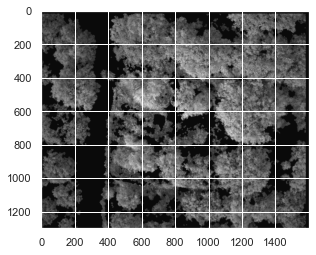

In [340]:
showimg(dvi*masklist[0])

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

In [341]:
def df_vi(vi, c, masklist):
    
    meanlist = []
    sizelist = []

    for m in masklist:
        meanlist.append(vi[m].mean())
        sizelist.append(vi[m].size)

    df_m = pd.DataFrame(meanlist)
    df_s = pd.DataFrame(sizelist)

    dfs = pd.concat([df_m,df_s],axis = 1)
    dfs.columns = [[VIname[c],VIname[c]],["meanBYtree","size"]]
    
    return dfs

In [342]:
dfs = df_vi(dvi,0,masklist)

c = 0
for vi in VIlist:
    if c != 0:
        print(c)
        df_c = df_vi(vi,c,masklist)
        dfs = pd.concat([dfs,df_c],axis = 1)
        c += 1
    else:
        c += 1

1
2
3
4
5
6
7
8
9


In [343]:
dfs.index.names = ["tree"]
dfs.columns.names = ["VIname","statistics"]

In [344]:
dfs_stack = dfs.stack()
dfs_stack

VIname                    DVI            GI         MSAVI          NDGI  \
tree statistics                                                           
0    meanBYtree  2.724820e-01  1.110007e+00  7.880647e-01  5.417688e-01   
     size        1.498242e+06  1.498242e+06  1.498242e+06  1.498242e+06   
1    meanBYtree  2.240245e-01  1.118749e+00  7.172562e-01  5.104389e-01   
     size        1.940380e+05  1.940380e+05  1.940380e+05  1.940380e+05   
2    meanBYtree  2.857999e-01  1.110402e+00  8.075777e-01  5.511505e-01   
...                       ...           ...           ...           ...   
46   size        3.200000e+01  3.200000e+01  3.200000e+01  3.200000e+01   
47   meanBYtree  1.390274e-01  1.042745e+00  5.854692e-01  4.107067e-01   
     size        1.770000e+02  1.770000e+02  1.770000e+02  1.770000e+02   
48   meanBYtree  1.269236e-01  1.052702e+00  5.639253e-01  4.061969e-01   
     size        1.450000e+02  1.450000e+02  1.450000e+02  1.450000e+02   

VIname                   NDRE          NDVI         OSAVI          RDVI  \
tree statistics                                                           
0    meanBYtree  5.691471e-01  5.691471e-01  4.207474e-01  3.902657e-01   
     size        1.498242e+06  1.498242e+06  1.498242e+06  1.498242e+06   
1    meanBYtree  5.465468e-01  5.465468e-01  3.886619e-01  3.474957e-01   
     size        1.940380e+05  1.940380e+05  1.940380e+05  1.940380e+05   
2    meanBYtree  5.772281e-01  5.772281e-01  4.306063e-01  4.026732e-01   
...                       ...           ...           ...           ...   
46   size        3.200000e+01  3.200000e+01  3.200000e+01  3.200000e+01   
47   meanBYtree  4.245691e-01  4.245691e-01  2.842149e-01  2.424744e-01   
     size        1.770000e+02  1.770000e+02  1.770000e+02  1.770000e+02   
48   meanBYtree  4.257148e-01  4.257148e-01  2.765788e-01  2.322380e-01   
     size        1.450000e+02  1.450000e+02  1.450000e+02  1.450000e+02   

VIname                   RGRI            SR  
tree statistics                              
0    meanBYtree           inf  3.957506e+00  
     size        1.498242e+06  1.498242e+06  
1    meanBYtree  9.054331e-01  3.660053e+00  
     size        1.940380e+05  1.940380e+05  
2    meanBYtree           inf  4.057648e+00  
...                       ...           ...  
46   size        3.200000e+01  3.200000e+01  
47   meanBYtree  9.697688e-01  2.556949e+00  
     size        1.770000e+02  1.770000e+02  
48   meanBYtree  9.571565e-01  2.541882e+00  
     size        1.450000e+02  1.450000e+02  

[98 rows x 10 columns]

In [345]:
dfs_stack.to_csv(str(rootpath)+"/result/"+str(imgNo)+"0_"+"dfs_include0.csv")

#### インデックスが0のところは，各樹のマスクをすべて足したもの(つまり全体平均)


■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

### 
#### 全体平均（インデックス＝０）を抜いたデータフレームdfs_m_ex0


In [346]:
dfs_m_ex0 = dfs.drop(0,axis = 0).drop(["size"],axis=1,level = 1)
dfs_m_ex0.columns = VIname
dfs_m_ex0

,DVI,GI,MSAVI,NDVI,NDGI,NDRE,OSAVI,RGRI,RDVI,SR
tree,,,,,,,,,,
1,0.224024,1.118749,0.717256,0.546547,0.510439,0.546547,0.388662,0.905433,0.347496,3.660053
2,0.285800,1.110402,0.807578,0.577228,0.551150,0.577228,0.430606,inf,0.402673,4.057648
3,0.179608,0.847619,0.661920,0.381802,0.453203,0.381802,0.284240,1.206127,0.261473,2.270760
4,0.158564,0.852061,0.623657,0.399834,0.467364,0.399834,0.284352,1.189915,0.251503,2.394604
5,0.110435,1.108860,0.534178,0.395087,0.353423,0.395087,0.250231,0.912477,0.208421,2.377362
6,0.146739,0.954951,0.600861,0.416554,0.438275,0.416554,0.285613,1.064044,0.246818,2.496607
7,0.109673,1.088895,0.533201,0.403057,0.368600,0.403057,0.253398,0.926633,0.210066,2.380050
8,0.113559,1.058512,0.539754,0.411379,0.389787,0.411379,0.259850,0.953618,0.215880,2.437266
9,0.097891,1.027112,0.513194,0.376199,0.367178,0.376199,0.232811,0.983443,0.191838,2.228618


In [347]:
dfs_m_ex0.to_csv(str(rootpath)+"/result/"+str(imgNo)+"0_"+"dfs_m_ex0.csv")

In [348]:
dfs_m_ex0.describe()

,DVI,GI,MSAVI,NDVI,NDGI,NDRE,OSAVI,RGRI,RDVI,SR
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.166589,0.959838,0.631739,0.426075,0.453482,0.426075,0.298246,inf,0.264180,2.563058
std,0.045786,0.217168,0.073908,0.044171,0.121609,0.044171,0.039985,NaN,0.044576,0.364517
min,0.097891,0.000000,0.513194,0.366091,0.353423,0.366091,0.232811,0.875185,0.191838,2.173162
25%,0.131935,0.958323,0.573760,0.398647,0.406316,0.398647,0.275551,0.961232,0.237117,2.376446
50%,0.160549,1.013187,0.629290,0.414392,0.430663,0.414392,0.291130,1.005304,0.259486,2.450969
75%,0.197773,1.050267,0.679889,0.446339,0.454155,0.446339,0.314207,1.064910,0.290602,2.655531
max,0.307843,1.146819,0.834312,0.577228,1.000000,0.577228,0.430606,inf,0.402673,4.057648


In [349]:
dfs_m_ex0.describe().to_csv(str(rootpath)+"/result/"+str(imgNo)+"0_"+"dfs_m_ex0_desctibe.csv")

In [350]:
filefile = os.listdir(str(rootpath)+"/result")
pathpath = [str(rootpath)+"/result/"+filename for filename in filefile]
pathpath

aa = pd.read_csv(pathpath[0], index_col = [0,1])
bb = pd.read_csv(pathpath[1], index_col = 0)
cc = pd.read_csv(pathpath[2], index_col = 0)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

### 
### 各樹の指標値のばらつき

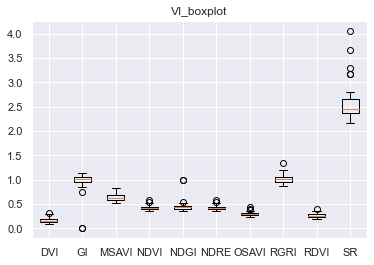

In [351]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("VI_boxplot")
ax.boxplot(dfs_m_ex0, labels = VIname)
plt.show()

fig.savefig(str(rootpath)+"/result/"+str(imgNo)+"0_"+"VI_boxplot", dpi = 200)

### 
### 各樹の指標値のばらつき
#### SRだけやたら値の範囲が大きめなので，SRだけ外して箱ひげ図を描いてみよう

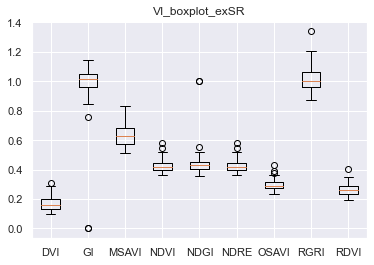

In [352]:
dfs_m_ex0_exSR = dfs_m_ex0.drop(["SR"],axis = 1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("VI_boxplot_exSR")
ax.boxplot(dfs_m_ex0_exSR, labels = VIname[0:9])
plt.show()

fig.savefig(str(rootpath)+"/result/"+str(imgNo)+"0_"+"VI_boxplot_exSR.png", dpi = 200)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

### 
### 各樹の大きさ（ピクセル数）のばらつき
#### やたら大きいピクセルがあるかも（外すべきかも）

<AxesSubplot:xlabel='tree'>

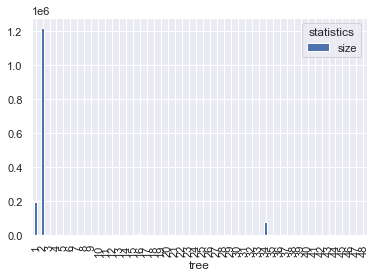

In [353]:
dfs_s_ex0 = dfs.drop(0,axis = 0).drop(["meanBYtree"],axis=1,level = 1).DVI
dfs_s_ex0.plot.bar()

In [354]:
VI = VIname[0]

dfs_s_ex0 = dfs[VI]["size"].drop(0)
dfs_s_ex0

tree
1      194038
2     1217650
3          60
4         136
5          87
6         356
7         269
8        1342
9         211
10         44
11         40
12        104
13         32
14        108
15         50
16       4321
17         66
18       1462
19         39
20        190
21        151
22         25
23         39
24         25
25         25
26         25
27         25
28         84
29         58
30        333
31         61
32         32
33        156
34      74202
35        638
36         47
37         72
38         74
39        184
40         32
41         46
42        737
43         40
44        101
45         71
46         32
47        177
48        145
Name: size, dtype: int64

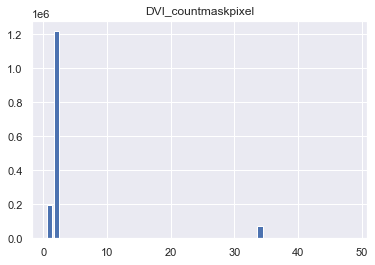

In [355]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title(str(VI)+"_countmaskpixel")
ax.bar(x=range(1,len(dfs[VI]["size"])), height=dfs_s_ex0)
plt.show()

fig.savefig(str(rootpath)+"/result/"+str(imgNo)+"0_"+str(VI)+"_countmaskpixel.png", dpi = 200)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

### 
### 変動係数を調べてみよう
### 

In [356]:
# 変動係数で各VIのばらつき程度を見る
std  = dfs_m_ex0.describe().iloc[2]
mean = dfs_m_ex0.describe().iloc[1]

# 変動係数 coefficient of variation
CV = std/mean

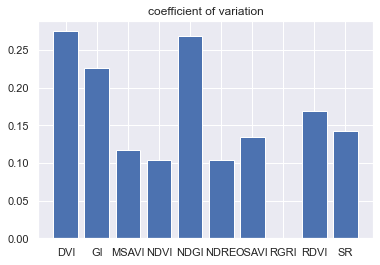

In [357]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("coefficient of variation")
ax.bar(x=VIname, height=CV)
plt.show()

fig.savefig(str(rootpath)+"/result/"+str(imgNo)+"0_VI_CV.png", dpi = 200)

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

### 
### ヒストグラム書いてみよう
### 

### matplotlibのめっちゃまとめ　を参考に
#### https://qiita.com/nkay/items/d1eb91e33b9d6469ef51

In [358]:
bins = math.ceil(1+math.log2(len(masklist)))

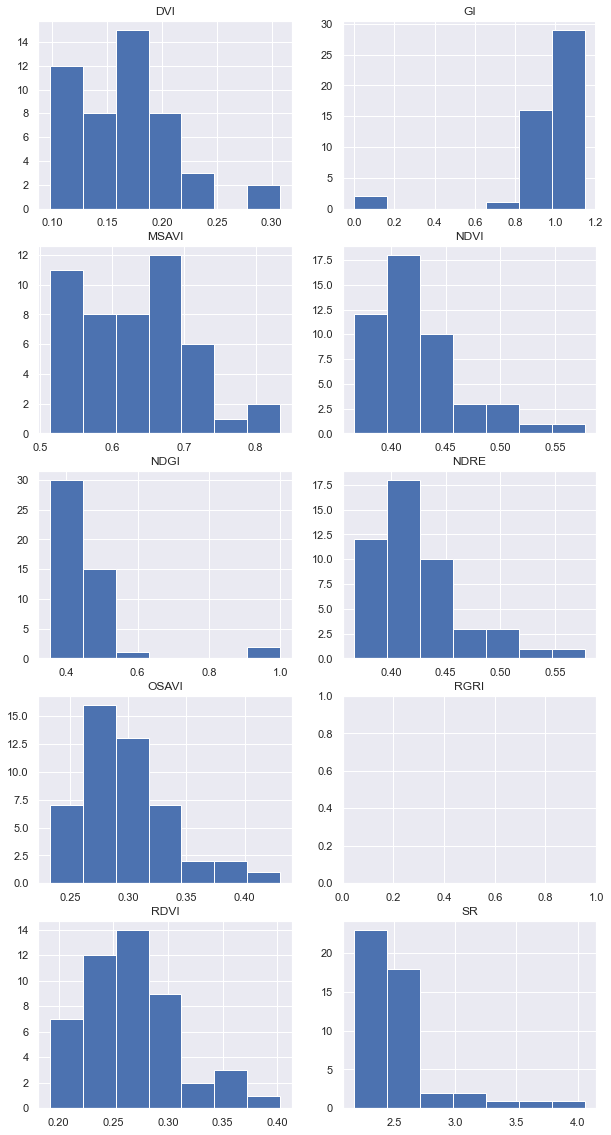

In [359]:
fig, axes = plt.subplots(5,2, figsize=(10,20))

c = 0
for a in range(5):
    for b in range(2):
        if c != 7:
            axes[a][b].set_title(VIname[c])
            axes[a][b].hist(x = dfs_m_ex0.iloc[:,c],bins = bins)
            c += 1
        else:
            axes[a][b].set_title(VIname[c])
            c += 1
plt.show()

fig.savefig(str(rootpath)+"/result/"+str(imgNo)+"0_VI_hist.png", dpi = 200)

0
1
2
3
4
5
6
7
8
9


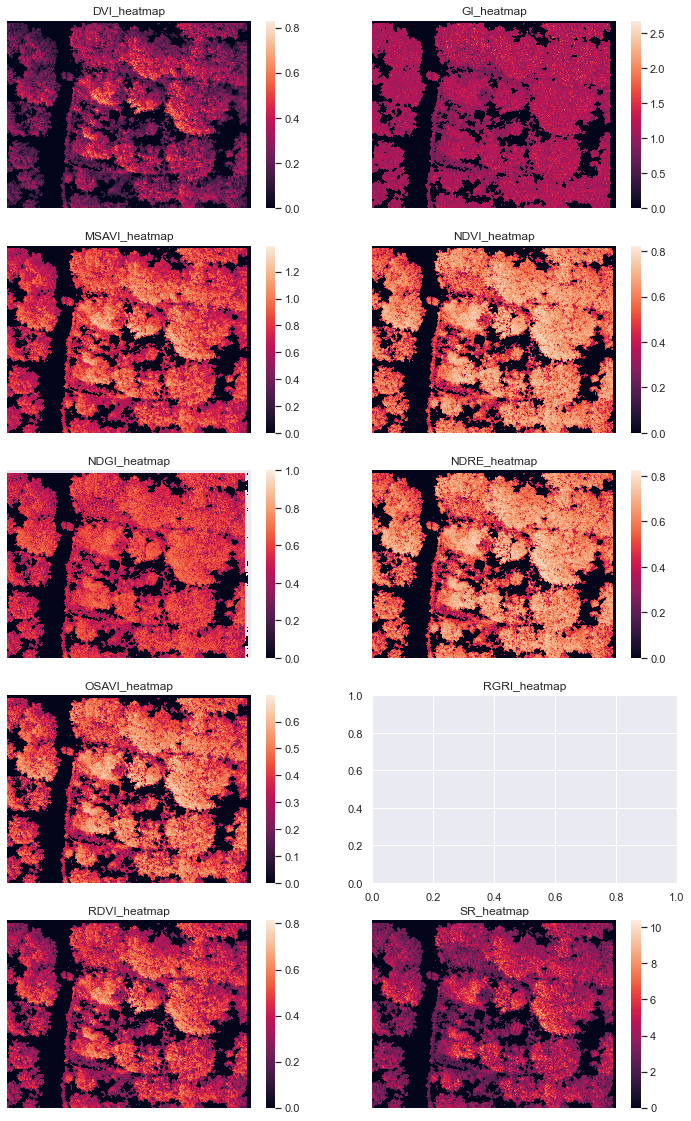

In [360]:
fig, axes = plt.subplots(5,2, figsize=(12,20))

c = 0

for a in range(5):
    for b in range(2):
        if c != 7:
            print(c)
            axes[a][b].set_title(str(VIname[c])+"_heatmap")
            sns.heatmap(VIlist[c]*masklist[0], ax=axes[a][b], vmin = 0)
            axes[a][b].set_xticks([])
            axes[a][b].set_yticks([])
            c += 1
        else:
            print(c)
            axes[a][b].set_title(str(VIname[c])+"_heatmap")
            c += 1
plt.show()

fig.savefig(str(rootpath)+"/result/"+str(imgNo)+"0_VI_heatmap.png", dpi = 200)